### Natalie Yurek - Analysis 2 Homework 2
#### Model Description 
This intially constructs the 2D (heterogeneous) steady state box model to describe the ACME and Wildcat Farm interactions
#### Dimensions: 
- 60 by 60 by 1
- dx = dy = 50 m
- dz = 400 m  
#### Subsurface Properties: 
- Heterogeneous 
- Hydraulic conductivity is K = 4.7, 7.25 m/day respectively as split down the center of the domain in x, y, and z
- Porosity = 0.3 (0.35 was the inital given)
- Specific yield = 0.15 (0.3 was inital given)
- Storage coefficient=0.001  (0.001 given as is a confined aquifer)
#### Boundary Conditions: 
 - Right boundary is constant head of (349.1) m relative to the datum, which is located at 200 m at the bottom of the domain.  
 - Left boundary is a constant head of (394.9) m relative to the datum, which is located at 200 m at the bottom of the domain.
 #### Scenarios
 - Most realistic/accurate guess
 - Best case
 - Worst case
 - Baseline background


## 1. Setup the environment

In [42]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as mpatches
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Supress depricaiton warmnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from scipy.stats import hmean

## 2. Create the model object

In [43]:
modelname = "BoxModel_flopy"
moddir = '../../../modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

In [44]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)


#### 3.1 Spatial discretization
3000 by 3000 grid domain

In [45]:
nrow = 60 #number of rows
ncol = 60 #number of columns
nlay = 1  #number of layers

dx= 50 #width of grid cells in x direction 
dy= 50 #height of grid cells in y direction 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 200    #top elevation 
zbot = -200     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

#### 3.2 Temporal discretization 

In [46]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [47]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

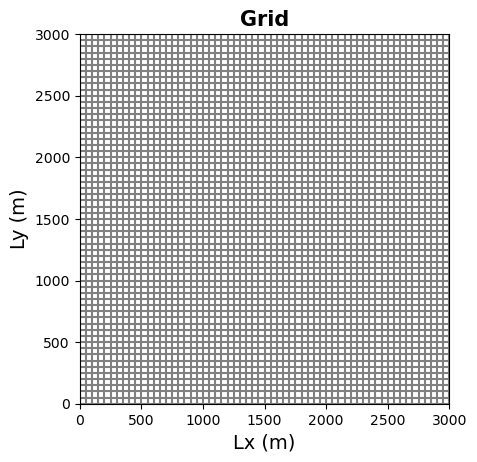

In [48]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup a grid for farm visualization

4.1 Creating Farm Areas

In [49]:
# Farm coordinates (x, y) in meters
acme = (0.0, 700.0) 
wildcat = (1500.0, 125.0) 

# Farm coordinates from (y, x) to (x, y)
acme_x0, acme_y0 = acme[1], acme[0]
wildcat_x0_raw, wildcat_y0 = wildcat[1], wildcat[0]
wildcat_x0 = 100.0

# Farm areas in acres
acme_acre = 500.0
wildcat_acre = 30.0

# conversion of acres to meters and farm areas
conversion = 4046.8564224
acme_m2 = acme_acre * conversion
wildcat_m2 = wildcat_acre * conversion

# ACME farm rectangular block height and width in meters
acme_width = np.sqrt(acme_m2 / 2)
acme_height = acme_width * 2

# Wildcat farm square block 
wildcat_hw = np.sqrt(wildcat_m2) # side length, height = width

# Assign farm bounds directly
acme_bounds = (800.0, 1800.0, 200.0, 2200.0)
wildcat_bounds = (200.0, 600.0, 1700.0, 2100.0)

# Convert to a usable domain
def bounds_to_domain(bounds, dx, dy, nrow):
    """
    Convert (xmin, xmax, ymin, ymax) in meters
    to MODFLOW (row, col) slice domain.
    """
    xmin, xmax, ymin, ymax = bounds

    col0 = int(xmin // dx)
    col1 = int(xmax // dx)

    # flip y for MODFLOW row indexing
    row1 = nrow - int(ymin // dy)
    row0 = nrow - int(ymax // dy)

    return (slice(row0, row1), slice(col0, col1))


In [50]:
def meters_to_cell(x, y, dx, dy, nrow):
    col = int(x // dx)
    row = nrow - 1 - int(y // dy)  
    return row, col

# ACME farm indices
acme_row0, acme_col0 = meters_to_cell(acme_x0, acme_y0, dx, dy, nrow=m.nrow)
acme_row1 = acme_row0 + int(acme_height // dy)
acme_col1 = acme_col0 + int(acme_width  // dx)

# Create slice object for easy indexing
acme_domain = (slice(acme_row0, acme_row1), slice(acme_col0, acme_col1))


# Wildcat farm indices
wildcat_row0, wildcat_col0 = meters_to_cell(wildcat_x0, wildcat_y0, dx, dy, nrow=m.nrow)
wildcat_row1 = wildcat_row0 + int(wildcat_hw // dy)
wildcat_col1 = wildcat_col0 + int(wildcat_hw // dx)

# Create slice object for easy indexing
wildcat_domain = (slice(wildcat_row0, wildcat_row1), slice(wildcat_col0, wildcat_col1))

# Create boolean masks for farm domains
acme_mask = np.zeros((m.nrow, m.ncol), dtype=bool)
wildcat_mask = np.zeros((m.nrow, m.ncol), dtype=bool)

acme_domain = bounds_to_domain(acme_bounds, dx, dy, m.nrow)
wildcat_domain = bounds_to_domain(wildcat_bounds, dx, dy, m.nrow)


In [51]:
# Convert (x,y) in meters to (row, col) for MODFLOW
def xy_to_rc(x, y, dx=dx, dy=dy, Ly=Ly):
    col = int(np.floor(x / dx))
    row = int(np.floor((Ly - y) / dy))  # row 0 at top of model
    return row, col

def inside_bounds(x, y, bounds):
    x0, x1, y0, y1 = bounds
    return (x0 <= x <= x1) and (y0 <= y <= y1)

def assert_min_spacing_xy(xy_list, min_dist_m=200.0):
    for i in range(len(xy_list)):
        for j in range(i+1, len(xy_list)):
            dx_ = xy_list[i][0] - xy_list[j][0]
            dy_ = xy_list[i][1] - xy_list[j][1]
            d = np.sqrt(dx_**2 + dy_**2)
            if d < min_dist_m:
                raise ValueError(f"Wells too close: {d:.1f} m < {min_dist_m} m between {xy_list[i]} and {xy_list[j]}")

### 4.2 Assigning Scenario Well Locations

In [52]:
# Spacing constraint: One well near and the other far
scenarios = {
    "average_case": {
        "acme_wells_xy": [(800.0, 2000.0), (1700.0, 300.0)],
        "note": "Two wells within ACME, one near, one far."
    },
    "best_case": {
        "acme_wells_xy": [(1700.0, 300.0), (1700.0, 500.0)],
        "note": "Two wells as far from Wildcat farm as possible (SE corner of ACME)."
    },
    "worst_case": {
        "acme_wells_xy": [(800.0, 2000.0), (1000.0, 2000.0)],
        "note": "Two wells as close to Wildcat as possible (W side of ACME)."
    },
     "normal_case": {
        "acme_wells_xy": [],
        "note": "No additional well pumping"
    }
}

In [53]:
for name, cfg in scenarios.items():
    wells_xy = cfg["acme_wells_xy"]
    assert_min_spacing_xy(wells_xy, min_dist_m=200.0)
    for (xw, yw) in wells_xy:
        if not inside_bounds(xw, yw, acme_bounds):
            raise ValueError(f"{name}: well {(xw, yw)} is outside ACME bounds {acme_bounds}")
        if not (0.0 <= xw <= Lx and 0.0 <= yw <= Ly):
            raise ValueError(f"{name}: well {(xw, yw)} is outside model domain 0..{Lx},0..{Ly}")
    cfg["acme_wells_rc"] = [(0, *xy_to_rc(xw, yw)) for (xw, yw) in wells_xy]  # (lay,row,col)
    print(f"\n{name}: {cfg['note']}")
    print("  ACME wells", wells_xy)
    print("  ACME wells", cfg["acme_wells_rc"])


average_case: Two wells within ACME, one near, one far.
  ACME wells [(800.0, 2000.0), (1700.0, 300.0)]
  ACME wells [(0, 20, 16), (0, 54, 34)]

best_case: Two wells as far from Wildcat farm as possible (SE corner of ACME).
  ACME wells [(1700.0, 300.0), (1700.0, 500.0)]
  ACME wells [(0, 54, 34), (0, 50, 34)]

worst_case: Two wells as close to Wildcat as possible (W side of ACME).
  ACME wells [(800.0, 2000.0), (1000.0, 2000.0)]
  ACME wells [(0, 20, 16), (0, 20, 20)]

normal_case: No additional well pumping
  ACME wells []
  ACME wells []


##### 4.2 Create Grid for Visualizing Farm Domains
##### Visualize farm domains on a grid

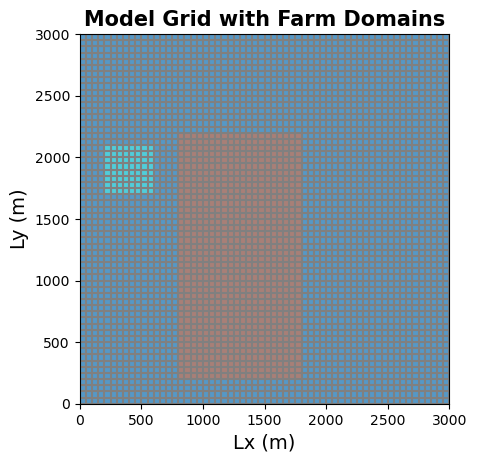

In [54]:
# Create map view of top layer
modelmap = flopy.plot.PlotMapView(model=m, layer=0)

# Plot base grid
modelmap.plot_grid()

# Build array for visualization only
farm_array = np.zeros((m.nrow, m.ncol), dtype=int)

# Mark farm domains
farm_array[acme_domain[0], acme_domain[1]] = 1
farm_array[wildcat_domain[0], wildcat_domain[1]] = 2

# Plot farms
modelmap.plot_array(
    farm_array,
    cmap=plt.cm.get_cmap('tab10', 3),
    alpha=0.5
)

# Labels
plt.xlabel('Lx (m)', fontsize=14)
plt.ylabel('Ly (m)', fontsize=14)
plt.title('Model Grid with Farm Domains', fontsize=15, fontweight='bold')

plt.show()

## 5. Setup constant head boundaries, active cells and initial heads (BAS Package)

#### 5.1 Define cell activity: IBOUND 
##### Keeps the model in a steady-state even when pumping is not equal to recharge

In [55]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 


#### 5.2 Define starting heads 
##### create linear gradient between W and E boundaries

In [56]:
#setup initial heads 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = 394.9   #replace first left col with desired head value
H_init[:, :, -1] = 349.1   #replace most right col with desired head value

# Fill interior cells with linear gradient left to right
H_init = np.zeros((nlay, nrow, ncol))

for j in range(ncol):
    H_init[0, :, j] = 394.9 - (394.9 - 349.1) * (j / (ncol - 1))

#for j in range(1, ncol-1):
#    H_init[:, :, j] = H_init[:, :, 0] - (H_init[:, :, 0] - H_init[:, :, -1]) * (j / (ncol-1))


#### 5.3 Create BAS object

In [57]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 5.4 Plot the grid and ibound

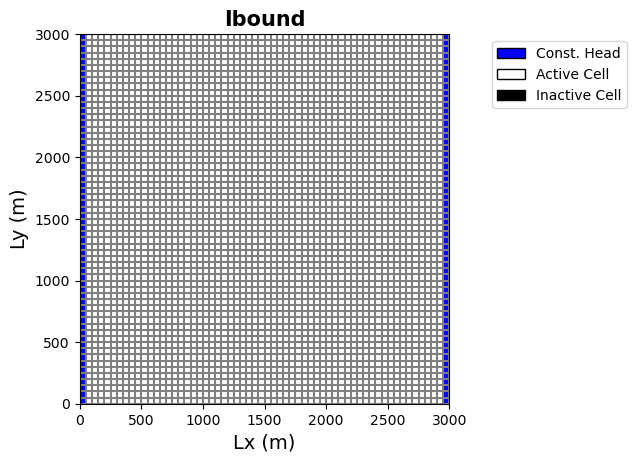

In [58]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

## 6. Setup Layer Properties  (LPF Package)

#### 6.1 Set layer properties

In [59]:
K_horiz = 6.8    #horizontal hydraulic conductivity 
K_vert = 6.8    #assign vertical hydraulic conductivity (along z axis)
n = 0.3        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.15        #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

#### 6.2 Make LPF object

In [60]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
#lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
#                             vka=K_vert, ss=Ss,
#                              sy=Sy,storagecoefficient=True, ipakcb=53) 


## 6b. Setup Cell-byCell Properties  (BCF Package)

#### 6b.1 Set cell properties and show K in top layer

Rectangular inclusion used to delineate the two regions of hydraulic conductivity

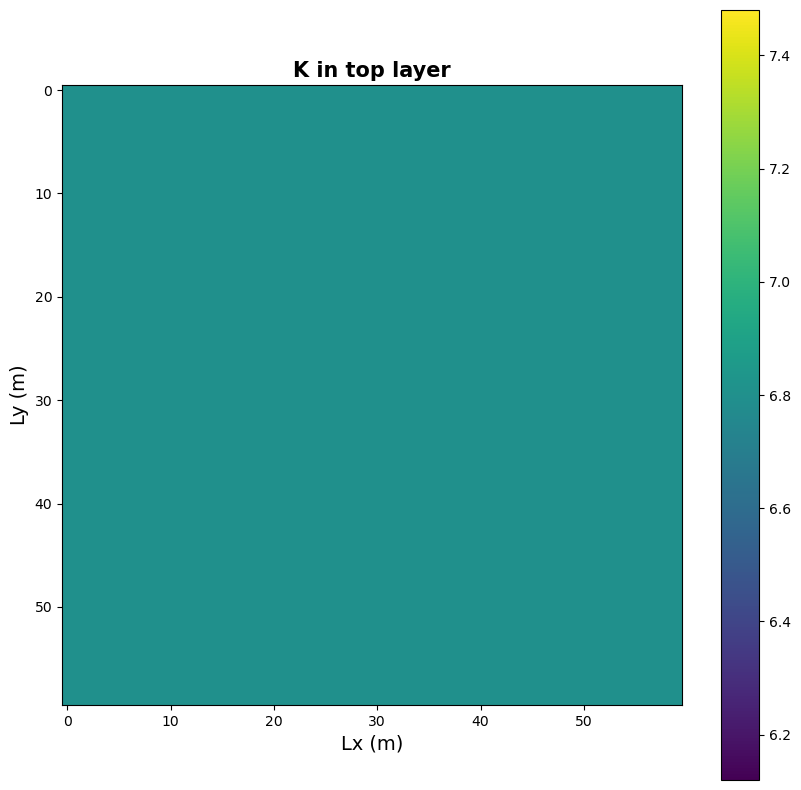

In [61]:
K_vals = np.zeros((nlay,nrow,ncol))
K_vals[:,:,:] = 6.8            # homogeneous background hydraulic conductivity  (4.7)
K_incl = 6.8 # K inclusion value (7.25)
K_vals[:, :, 0:30] = K_incl #adj layer, adj rows, adj columns


n = 0.3        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.15       #assign specific yield
uncnf = 0       #0=confined, >0 = unconfined

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.imshow(np.flipud(K_vals[0,:,:]), interpolation='none')
plt.colorbar()
plt.show()

#### 6b.2 Make BCF object

In [62]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], vcont=1, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 7. Setup outputs by stress period (OC Package)

#### 7.1 Setup outputs

In [63]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### 7.2 Make OC object 

In [64]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 8. Set the numerical solver (PCG Package)

#### 8.1 Make the PCG object

In [65]:
pcg = flopy.modflow.ModflowPcg(model=m)

#### 9.0 Add Recharge values across the domain 
##### -RCH Package-

In [66]:
# Recharge applied to non-farm areas only

R_background = 1e-4  # m/day (net natural recharge)

# Cell-center coordinates
x_centers = (np.arange(ncol) + 0.5) * dx
y_centers = Ly - (np.arange(nrow) + 0.5) * dy
Xc, Yc = np.meshgrid(x_centers, y_centers)

def bounds_mask(bounds):
    x0, x1, y0, y1 = bounds
    return (Xc >= x0) & (Xc <= x1) & (Yc >= y0) & (Yc <= y1)

# Farm masks
acme_mask = bounds_mask(acme_bounds)
wildcat_mask = bounds_mask(wildcat_bounds)
non_farm_mask = ~(acme_mask | wildcat_mask)

# Recharge array
rech_zone = np.zeros((nrow, ncol))
rech_zone[non_farm_mask] = R_background  # m/day outside farms

# Total recharge (m³/day)
cell_area = dx * dy
Q_recharge_m3_per_day = rech_zone.sum() * cell_area

# RCH package
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)

# Print check
print(f'Total recharge (non-farm areas only): {Q_recharge_m3_per_day:,.1f} m^3/day')
print(f'Cells: ACME={acme_mask.sum()}, Wildcat={wildcat_mask.sum()}, Non-farm={non_farm_mask.sum()}')

Total recharge (non-farm areas only): 684.0 m^3/day
Cells: ACME=800, Wildcat=64, Non-farm=2736


## 10. Setup run and choose scenario

#### 10.1 Setup pumping rates

In [67]:
# Pumping rates as determined from consumptive water use (in/yr) * farm area.
inches_m = 0.0254
cotton_in_per_yr = 41.2   # ACME grows cotton with this consumptive use value (41.2)
alfalfa_in_per_yr = 74.3  # Wildcat grows alfalfa with this consumptive use value (74.3)

def depth_m_per_day(in_per_yr):
    return (in_per_yr * inches_m) / 365.0

# Use model area not acres
cell_area_m2 = dx * dy
acme_area_m2_model = float(acme_mask.sum() * cell_area_m2)
wildcat_area_m2_model = float(wildcat_mask.sum() * cell_area_m2)

# Convert to volume (m^3/day)
Q_acme_total = depth_m_per_day(cotton_in_per_yr)  * acme_area_m2_model      
Q_wildcat    = depth_m_per_day(alfalfa_in_per_yr) * wildcat_area_m2_model   
Q_acme_each = Q_acme_total / 2.0

print(f"ACME model area: {acme_area_m2_model:,.0f} m^2  (cells={int(acme_mask.sum())})")
print(f"Wildcat model area: {wildcat_area_m2_model:,.0f} m^2  (cells={int(wildcat_mask.sum())})")
print(f"ACME total pumping total: {Q_acme_total:,.1f} m^3/day (each {Q_acme_each:,.1f})") # ACME 2 wells
print(f"Wildcat pumping total: {Q_wildcat:,.1f} m^3/day") # Wildcat 1 well

ACME model area: 2,000,000 m^2  (cells=800)
Wildcat model area: 160,000 m^2  (cells=64)
ACME total pumping total: 5,734.1 m^3/day (each 2,867.1)
Wildcat pumping total: 827.3 m^3/day


#### 10.2 Constant (value and location) pumping within Wildcat farm

In [68]:
# Wildcat well at center of farm
wildcat_xc = 0.5 * (wildcat_bounds[0] + wildcat_bounds[1])
wildcat_yc = 0.5 * (wildcat_bounds[2] + wildcat_bounds[3])
wildcat_row, wildcat_col = xy_to_rc(wildcat_xc, wildcat_yc)

#### 10.3 Choosing a scenario
##### !ACTION! Please input one of four options 1. average_case 2. best_case 3. worst_case 4. normal_case

In [69]:
# The four options: 
# normal_case - No additional wells
# average_case- Average, wells split across domain
# best_case- Both wells far from Wildcat
# worst_case- Both wells near Wildcat
scenario_name = 'normal_case'
acme_wells_rc = scenarios[scenario_name]['acme_wells_rc']

In [70]:
# Build stress period data (Pumping/water extraction is negative)
wel_spd = []
# Wildcat (constant)
wel_spd.append([0, wildcat_row, wildcat_col, -Q_wildcat])
# Changing ACME wells (x2)
for (lay, r, c) in acme_wells_rc:
    wel_spd.append([lay, r, c, -Q_acme_each])

wel = flopy.modflow.ModflowWel(m, stress_period_data={0: wel_spd})

#(0,0) Saves data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period 

## 11. Inputing and display of the Water Balance

In [71]:
Q_pump_total = Q_wildcat + Q_acme_total
print(f"Scenario: {scenario_name} -> {scenarios[scenario_name]['note']}")
print(f'Wildcat pumping: {Q_wildcat:,.1f} m^3/day')
print(f'ACME total pumping (2 wells): {Q_acme_total:,.1f} m^3/day (each {Q_acme_each:,.1f})')
print(f'Total pumping: {Q_pump_total:,.1f} m^3/day')
print(f'Recharge (non-irrigated only): {Q_recharge_m3_per_day:,.1f} m^3/day')

Scenario: normal_case -> No additional well pumping
Wildcat pumping: 827.3 m^3/day
ACME total pumping (2 wells): 5,734.1 m^3/day (each 2,867.1)
Total pumping: 6,561.4 m^3/day
Recharge (non-irrigated only): 684.0 m^3/day


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [72]:
m.write_input()    #uses the package objects we've created above to write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [73]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: BoxModel_flopy.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12 21:11:05

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12 21:11:05
 Elapsed run time:  0.049 Seconds

  Normal termination of simulation


## 11. Plot the results  

#### 11.1 Read in the model outputs

##### Read the heads 

In [74]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

##### Write Heads as csv

In [75]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])

##### Read the Water Balance and use it to find distribution of fluxes along boundary

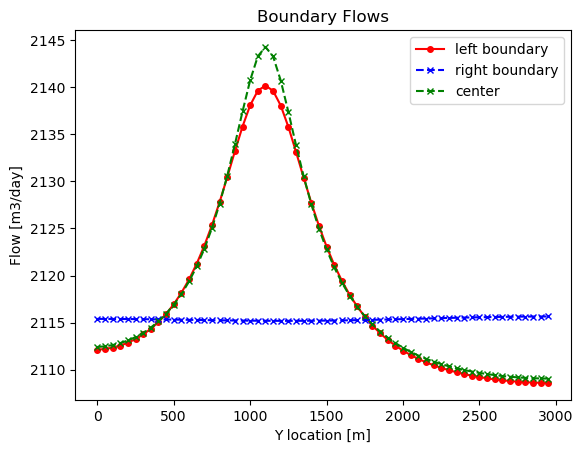

(60, 60)
2112.514
2112.6133
[2112.34   2112.514  2112.6133 2112.6418 2112.6045 2112.5083 2112.3608
 2112.1711 2111.9482 2111.7017 2111.4407 2111.174  2110.9097 2110.6543
 2110.4133 2110.1914 2109.9917 2109.8167 2109.6675 2109.5442 2109.447
 2109.3755 2109.3281 2109.3042 2109.302  2109.3206 2109.358  2109.413
 2109.4846 2109.571  2109.6716 2109.7852 2109.9106 2110.047  2110.1938
 2110.3503 2110.5156 2110.6892 2110.87   2111.058  2111.2524 2111.4526
 2111.6582 2111.8687 2112.0837 2112.3025 2112.5251 2112.751  2112.98
 2113.2114 2113.4456 2113.682  2113.9204 2114.161  2114.403  2114.647
 2114.8923 2115.1394 2115.388     0.    ]


In [76]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
#centerflux = flux_vals[:,12]
centerflux = flux_vals[:,2]


bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.plot(x,centerflux,marker='x', color='green', markersize=4, linestyle='--',label="center")
plt.xlabel('Y location [m]')
plt.ylabel('Flow [m3/day]')
plt.title("Boundary Flows")
plt.legend()
plt.show()

print(flux_vals.shape)
print(flux_vals[2,1])
print(flux_vals[2,2])
print(flux_vals[2,:])



### Calculate the total flux

In [77]:
#Calculate the total flux across the model
flux_tot  = np.sum(flux_vals[:, 0]) #total flux through one column of the model [m3/day]

# Calculate the equivalent K (q=k*A* dh/dl)
area = nrow *dy * (ztop-zbot)
dh_dl= (H_init[0,0,0]-H_init[0,0,-1])/Lx
#dh_dl = 10/2500
k_eff = flux_tot/area/dh_dl

# Calculate the arithmetic mean K
k_arr = np.mean(K_vals)

# Calcualte the harmonic mean K
k_harm = hmean(K_vals.flatten()) 

print("LowK", K_incl, "ArrMean", np.round(k_arr,2), "Hmean", np.round(k_harm,2), "Keff", np.round(k_eff,2), "Q", np.round(flux_tot,2) )


LowK 6.8 ArrMean 6.8 Hmean 6.8 Keff 6.94 Q 127095.05


#### 11.2 Evaluate the head gradients

Head Gradient 0.015266662 m/m


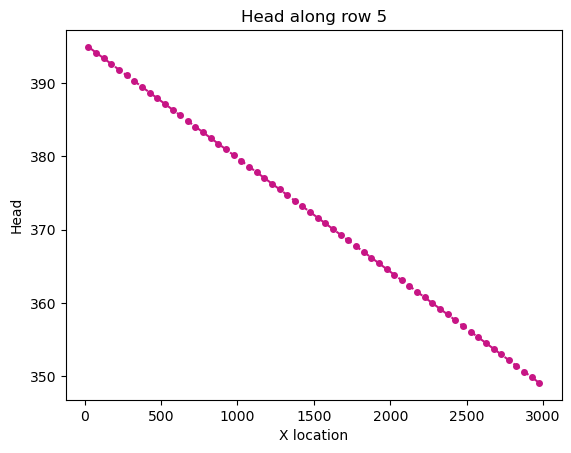

In [78]:
head_fig = plt.figure() 
x=np.arange(dx/2,Lx,dx)
y=head[0,4,:]
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 5")

hgrad=(head[0,4,0]-head[0,4,-1])/Lx
print("Head Gradient", hgrad, "m/m") 

#### 11.3 3D plot of heads

Text(0.5, 0.92, 'Steady-State Model Head Profile')

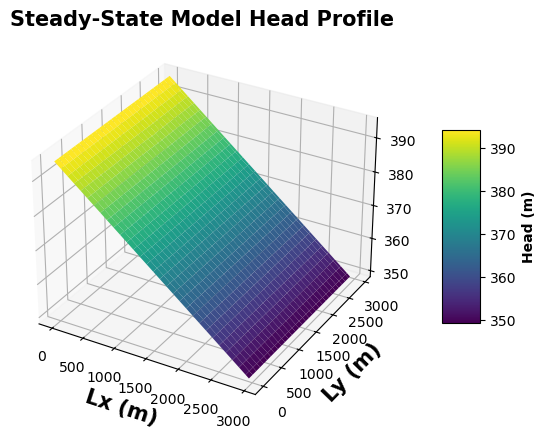

In [79]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')

### 11.4 Contour Head plot

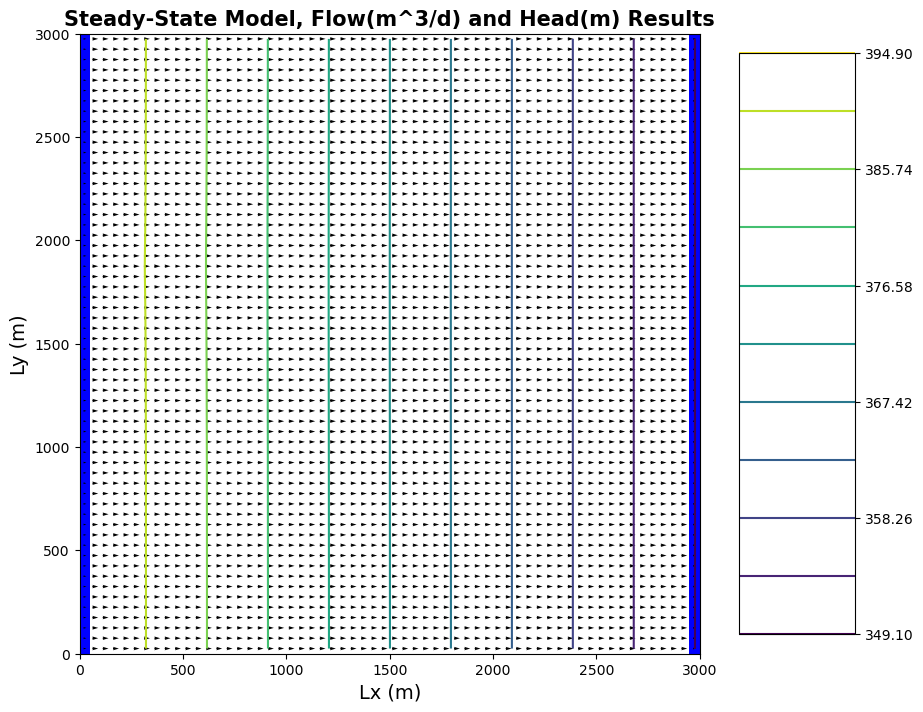

In [80]:
#Calculate the volumetric dischard (m3/day)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf[0], fff[0], None), m) 

#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
quiver = modelmap.plot_vector(qx, qy)

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)

## Individual Scenario Contour Map

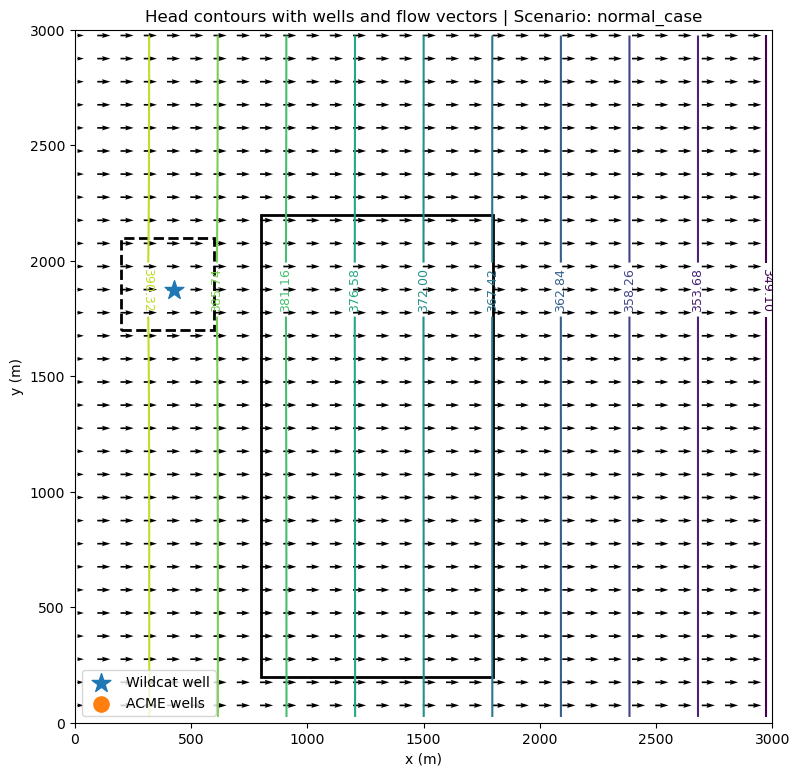

In [81]:
# Coordinates for plotting well markers (cell centers)
def rc_to_xy_center(row, col, dx=dx, dy=dy, Ly=Ly):
    x = (col + 0.5) * dx
    y = Ly - (row + 0.5) * dy
    return x, y

wildcat_xy_plot = rc_to_xy_center(wildcat_row, wildcat_col)
acme_xy_plot = [rc_to_xy_center(r, c) for (_, r, c) in acme_wells_rc]

# Create new window and axes
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)

pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

# Head contours
levels = np.linspace(np.nanmin(head[0]), np.nanmax(head[0]), 11)
cs = pmv.contour_array(head[0], levels=levels)
plt.clabel(cs, inline=1, fontsize=9)

# Specific discharge vectors (optional; comment out for a cleaner figure)
try:
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf[0], fff[0], None), m)
    pmv.plot_vector(qx, qy, istep=2, jstep=2)
except Exception as e:
    print("Note: could not plot specific discharge vectors:", e)
    
# Farm outlines
acme_rect = mpatches.Rectangle((acme_bounds[0], acme_bounds[2]),
                               acme_bounds[1]-acme_bounds[0],
                               acme_bounds[3]-acme_bounds[2],
                               fill=False, linewidth=2, edgecolor='k')
wildcat_rect = mpatches.Rectangle((wildcat_bounds[0], wildcat_bounds[2]),
                                  wildcat_bounds[1]-wildcat_bounds[0],
                                  wildcat_bounds[3]-wildcat_bounds[2],
                                  fill=False, linewidth=2, edgecolor='k', linestyle='--')
ax.add_patch(acme_rect)
ax.add_patch(wildcat_rect)

# Well markers
ax.scatter([wildcat_xy_plot[0]], [wildcat_xy_plot[1]], marker='*', s=200, label='Wildcat well')
ax.scatter([p[0] for p in acme_xy_plot], [p[1] for p in acme_xy_plot], marker='o', s=120, label='ACME wells')

# Labels + limits
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_title(f"Head contours with wells and flow vectors | Scenario: {scenario_name}")
ax.legend(loc="lower left")

## Create depletion map

[[394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]
 [394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]
 [394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]
 ...
 [394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]
 [394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]
 [394.9        394.12372881 393.34745763 ... 350.65254237 349.87627119
  349.1       ]]
[[394.9     394.12347 393.3469  ... 350.65536 349.87772 349.1    ]
 [394.9     394.12344 393.34683 ... 350.65533 349.87772 349.1    ]
 [394.9     394.1234  393.34674 ... 350.65533 349.87772 349.1    ]
 ...
 [394.9     394.12476 393.34943 ... 350.65555 349.8778  349.1    ]
 [394.9     394.12476 393.34946 ... 350.65555 349.8778  349.1    ]
 [394.9     394.1248  393.34946 ... 350.65555 349.8778  349.1    ]]


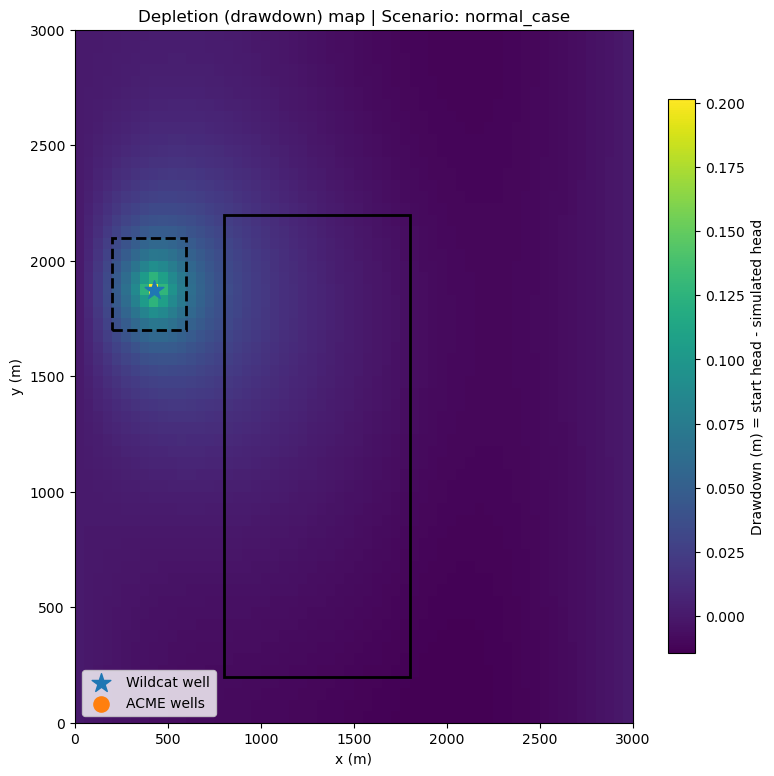

In [82]:
drawdown = H_init[0, :, :] - head[0, :, :]

# Optional: focus on small drawdowns
# vmax can be set as a fixed small value (e.g., 10 m) or a percentile
vmax = np.percentile(drawdown, 99)  # ignore extreme spikes
vmin = 0  # always start at 0

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

# Drawdown as a color scale
arr = pmv.plot_array(drawdown)
plt.colorbar(arr, ax=ax, shrink=0.8, label="Drawdown (m) = start head - simulated head")

# Farm outlines
acme_rect = mpatches.Rectangle((acme_bounds[0], acme_bounds[2]),
                               acme_bounds[1]-acme_bounds[0],
                               acme_bounds[3]-acme_bounds[2],
                               fill=False, linewidth=2)
wildcat_rect = mpatches.Rectangle((wildcat_bounds[0], wildcat_bounds[2]),
                                  wildcat_bounds[1]-wildcat_bounds[0],
                                  wildcat_bounds[3]-wildcat_bounds[2],
                                  fill=False, linewidth=2, linestyle='--')
ax.add_patch(acme_rect)
ax.add_patch(wildcat_rect)

# Well markers
ax.scatter([wildcat_xy_plot[0]], [wildcat_xy_plot[1]], marker='*', s=200, label='Wildcat well')
ax.scatter([p[0] for p in acme_xy_plot], [p[1] for p in acme_xy_plot], marker='o', s=120, label='ACME wells')

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_title(f"Depletion (drawdown) map | Scenario: {scenario_name}")
ax.legend(loc="lower left")

print(H_init[0, :, :])
print(head[0, :, :])